In [2]:
%pylab inline
from scipy.spatial.distance import cdist

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
def find_dists(X,rep):
    C=cdist(X,rep)
    index=argmin(C,axis=1)
    dist=np.min(C,axis=1)
    return index,dist

def find_cover_iter(rep,X,epsilon=1,debug=False) :
    m=X.shape[0]
    found=False
    for i in range(m):
        x=X[i:i+1,:]  # can make more efficient by checking several at once and keeping 
                      # track of the location of the last find.
        _,dist=find_dists(x,rep)
        if np.min(dist)>epsilon:
            if debug:
                print(i,np.min(dist),rep.shape)
            rep=concatenate([rep,x],axis=0)
            found=True
    return rep,found

def source(m,n):
    " a generator of example batches"
    while True:
        yield (rand(m,n)*2)-1

def find_cover(rep,source,epsilon=1,debug=False):
    found=True; j=0
    cover=rep
    for X in source():
        cover,found=find_cover_iter(cover,X,epsilon=epsilon,debug=debug)
        if debug:
            print('### round ',j,cover.shape); j+=1
        if not found:
            break
    return cover

def split(X,cover):
    """ Partition rows in X according to the cclosest row in cover"""
    index,dist = find_dists(X,cover)
    
    subset=[]
    for i in range(cover.shape[0]):
        s=X[nonzero(index==i),:]
        subset.append(s[0,:,:])
    return subset

In [4]:
n=2;
m=3
rep=eye(n)
X=concatenate([eye(n)*(1+0.1*i) for i in range(m)],axis=0)
X.shape

(6, 2)

In [5]:
X

array([[1. , 0. ],
       [0. , 1. ],
       [1.1, 0. ],
       [0. , 1.1],
       [1.2, 0. ],
       [0. , 1.2]])

In [6]:
index,dist = find_dists(X,rep)

In [7]:
index

array([0, 1, 0, 1, 0, 1])

In [8]:
dist

array([0. , 0. , 0.1, 0.1, 0.2, 0.2])

### finding a cover

In [9]:
%%time
n=2
rep=array([zeros(n)])
rep.shape
epsilon=0.5
m=10000

def source():
    while True:
        yield (rand(m,n)*2)-1
        
cover=find_cover(rep,source,epsilon=epsilon)

CPU times: user 523 ms, sys: 6.83 ms, total: 529 ms
Wall time: 557 ms


In [12]:
cover.shape

(15, 2)

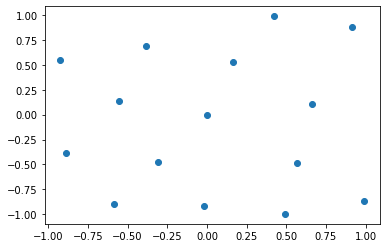

In [13]:
scatter(cover[:,0],cover[:,1])

### Split Examples

In [14]:
X=source().__next__()


index.shape, X.shape

((6,), (10000, 2))

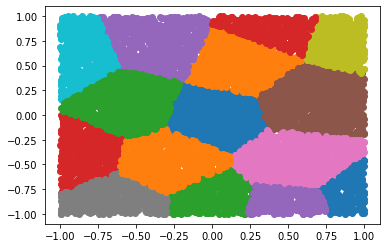

In [15]:
subset=split(X,cover)

for s in subset:
    scatter(s[:,0],s[:,1])

In [16]:
data=[]
j=0
for x in source():
    break
x.shape

(10000, 2)

In [17]:
x.dump('square.npy')

In [18]:
!ls -l square.npy

-rw-r--r--  1 robibhatt  staff  249778 Jul 19 09:30 square.npy


In [19]:
import numpy as np
from scipy.spatial import distance_matrix
from scipy.stats import norm
from sklearn.neighbors import BallTree

In [119]:
class MatrixIterator:
    
    def __init__(self,centers, source_radius, source, Cg=1.0,sigma=3.0,iterations=200,tolerance=1e-4):
        #dim=1    #dimension of space                                                                                                                                                            
        #n = 10  #number of samples                                                                                                                                                              
        #sigma=0.2  #width of Gaussian                                                                                                                                                           
        #iterations=10 # number of iteration of averaging recursion                                                                                                                              
        #_tolerance = 1e-4 # stop afteer error is below _tolerance
        self.centers=centers
        (n, dim) = centers.shape
        self.n=n
        self.dim = dim
        
        self.sigma = sigma
        self.Cg = Cg
        self.iterations=iterations
        self.tolerance=tolerance
        self.set_sources(source_radius, source)
        
    def set_sources(self, source_radius, source):
        tree = BallTree(self.centers)
        print(source)
        print(self.centers)
        self.ind = tree.query_radius([source], source_radius)[0]

    def make_transition_matrix(self):
        # compute recursion matrix (W)                                                                                                                                                       
        A=distance_matrix(self.centers, self.centers)
        Adgacency=norm.pdf(A,scale=self.sigma)
        W=Adgacency/(sum(Adgacency,axis=1)+self.Cg)
        return W
    
    def solve(self):
        vec = np.zeros(self.n)
        np.put(vec, self.ind, 1.)
        W = self.make_transition_matrix()
        for i in range(self.iterations):
            vec = np.dot(W, vec)
            np.put(vec, self.ind, 1.)
        print(vec)


In [120]:
mat_it = MatrixIterator(cover, 0.1, cover[0])

[0. 0.]
[[ 0.          0.        ]
 [ 0.16623511  0.52980661]
 [-0.01566046 -0.91394672]
 [-0.88476912 -0.38311261]
 [-0.38492801  0.69262725]
 [ 0.66087493  0.10570087]
 [ 0.56764158 -0.485546  ]
 [-0.58532054 -0.90048162]
 [ 0.91330729  0.8765137 ]
 [-0.92491565  0.54505158]
 [ 0.99191441 -0.86307636]
 [-0.30807691 -0.47741306]
 [-0.55201324  0.13269954]
 [ 0.42084196  0.98822018]
 [ 0.49363546 -0.99666032]]


In [121]:
matrix = mat_it.make_transition_matrix()
matrix.shape

(15, 15)

In [126]:
mat_it.solve()

[1.         0.11220049 0.10986079 0.10876303 0.1100555  0.11171849
 0.11139137 0.10784135 0.10460722 0.10692629 0.1048805  0.11259529
 0.11216692 0.1070063  0.10767516]


In [123]:
print(matrix)

[[0.04576039 0.04557829 0.04473954 0.04487839 0.04536926 0.04529337
  0.04505151 0.04450283 0.04434034 0.04488921 0.0438064  0.04536782
  0.04554728 0.0448453  0.04428641]
 [0.04498322 0.04636574 0.04166399 0.04243324 0.04612563 0.04535228
  0.04349209 0.0410423  0.04667613 0.04479382 0.04168597 0.04311536
  0.04466709 0.04708886 0.04142959]
 [0.04368478 0.04121991 0.04686526 0.04461106 0.04039676 0.04272814
  0.0451372  0.04659977 0.03866276 0.04061096 0.04557138 0.04548585
  0.04294055 0.03869514 0.04674046]
 [0.04345713 0.04163297 0.04424127 0.04725698 0.04344729 0.04012695
  0.04130683 0.04651533 0.03708284 0.04561689 0.03914852 0.04532089
  0.04540968 0.03917881 0.04180147]
 [0.04419163 0.04552271 0.04029824 0.0437036  0.04697983 0.04286889
  0.04090606 0.04111625 0.0440535  0.04703156 0.03794172 0.04279217
  0.04549895 0.04589646 0.03878293]
 [0.0446357  0.04528499 0.0431244  0.04083759 0.04337222 0.04643463
  0.04555413 0.04114538 0.04672919 0.04117359 0.04549468 0.04302103
  0.

In [124]:
np.dot(matrix, np.ones(mat_it.n))

array([0.67425633, 0.6609153 , 0.64994999, 0.64154385, 0.6475845 ,
       0.65945092, 0.65861431, 0.63754258, 0.61705167, 0.62913211,
       0.62186921, 0.66463266, 0.66066518, 0.63027964, 0.63793153])